In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

import warnings
warnings.filterwarnings("ignore")

In [25]:
#import data 

all_posts = pd.read_csv('./labelled_posts/all_posts_labelled.csv')
all_posts.head()

,post,label,date,source,post_clean_rnn,post_clean_nb_logreg
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,for consistency and accuracy it could be easie...,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,only iq lower than 86 will believe this csb wh...,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,i work nearby to the westlite and toh guan dor...,work nearby westlite toh guan initial reports ...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh liao,ho seh


In [26]:
#drop date (which is not accurate), post_clean_rnn, post_clean_nb_logreg

all_posts.drop(columns = ['date', 'post_clean_rnn', 'post_clean_nb_logreg'], inplace=True)
all_posts.head(2)

,post,label,source
0,There is no new cluster beside the dorm for tw...,2.0,hardwarezone
1,">For consistency and accuracy, it could be eas...",0.0,reddit


In [27]:
#preprocess words in post 

#dealing with stopwords 

#first cut - removing words from stopwords that indicate sentiment 
# remove_words = ["no", "not", "against", "don't", "should", "should've", "couldn", "couldn't",'didn', "didn't",
#                    'doesn',"doesn't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",
#                    'wouldn',"wouldn't"]
# stopwords = [word for word in stopwords.words('english') if word not in remove_words]

stopwords = stopwords.words('english')
print(len(stopwords))

# also adding words that are either common words, singaporean slang or noisy words from forum posts

# add_words = ['foreign', 'migrant', 'worker', 'workers', 'fw', 'dorm', 'dorms', 'dormitory', 'dormitories', 'covid', 
#              '19', 'cases', 'virus', 'coronavirus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung',
#             'xiaomi', 'l21a', '32']

# add_words = ['foreign', 'migrant', 'worker', 'workers', 'fw', 'dorm', 'dorms', 'dormitory', 'dormitories', 'covid', 
#              '19', 'cases', 'virus', 'coronavirus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung',
#             'xiaomi', 'l21a', '32', 'government', 'gov', 'govt']

# add_words = ['foreign', 'migrant', 'worker', 'workers', 'fw', 'covid', '19', 'cases', 'virus', 'coronavirus', 
#       'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung','xiaomi', 'l21a', '32', 'government', 'gov', 'govt']

add_words = ['19', 'virus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung',
            'xiaomi', 'l21a', '32']
stopwords.extend(add_words)
len(stopwords)

179


191

In [29]:
def preprocess(word):
     
    # tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
    
   #remove stopwords 
    no_stop = [word for word in tokens if word not in stopwords]

    no_stopword = (' '.join(no_stop))
        
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in no_stopword]
    
    #return words as a single string 
    return(''.join(lem))

In [30]:
post_clean = []

for p in all_posts["post"]:
    post_clean.append(preprocess(p))

print(f"checking post_clean: \n{post_clean[0:3]}")

all_posts['post_clean_lda'] = post_clean
all_posts.head()

checking post_clean: 
['new cluster beside dorm two days', 'consistency accuracy could easier use data new moh situation report separates dorm non dorm foreigners citizen pr think count named dorm clusters dorm either linked construction sites live non cluster dorms get categorized linked clusters pending investigations respectively moh situation report 28 3 10 4 ltp holders 545 linked dorm clusters 126 linked clusters 141 pending investigations whereas estimate time period 702 dorm construction related reason make graphs really 2 separate covid problems singapore circuit breaker slow growth cases general public stopping work construction sites circuit breaker help dorm construction site problem dorm construction site problem tackled improving living conditions workers testing separating sick well conversely issues way many people exercising eating hawker centres sneakily meeting etc affect non dorm problem yes testing situation worrisome know prioritizing tests would political suicide

,post,label,source,post_clean_lda
0,There is no new cluster beside the dorm for tw...,2.0,hardwarezone,new cluster beside dorm two days
1,">For consistency and accuracy, it could be eas...",0.0,reddit,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,hardwarezone,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,reddit,work nearby westlite toh guan dorms initial re...
4,Ho seh liao,0.0,hardwarezone,ho seh


In [31]:
#combine gov, govt to government 
#combine dorm, dorms, dormitories to dormitory 

all_posts['post_clean_lda'] = all_posts['post_clean_lda'].str.replace('dormitories ', 'dormitory ')
all_posts['post_clean_lda'] = all_posts['post_clean_lda'].str.replace('dorm ', 'dormitory ')
all_posts['post_clean_lda'] = all_posts['post_clean_lda'].str.replace('dorms ', 'dormitory ')
all_posts['post_clean_lda'] = all_posts['post_clean_lda'].str.replace('gov ', 'government ')
all_posts['post_clean_lda'] = all_posts['post_clean_lda'].str.replace('govt ', 'government ')

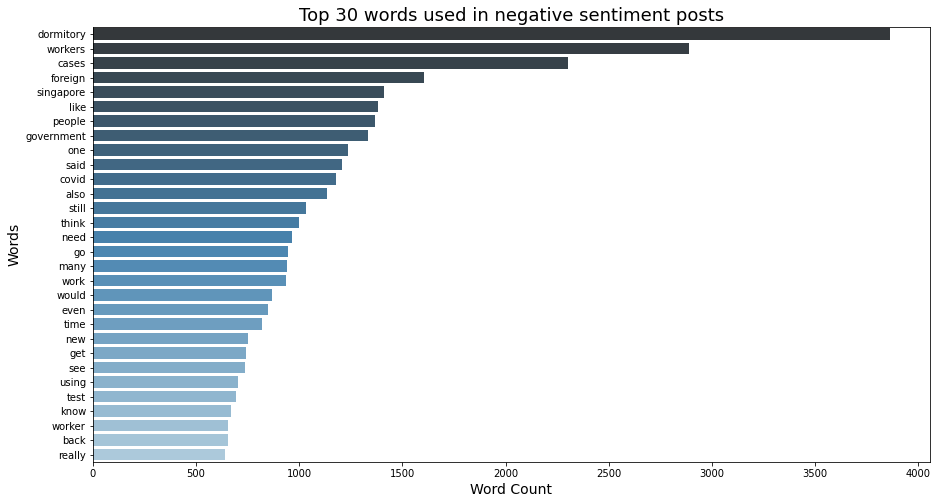

In [32]:
#barplot of most commonly used words 

#cvec and sort by most common words
cvec = CountVectorizer()
cvec_posts = pd.DataFrame(cvec.fit_transform(all_posts['post_clean_lda']).toarray(), 
                         columns=cvec.get_feature_names())

wordcount_df = pd.DataFrame(cvec_posts.sum().sort_values(ascending=False).head(30),columns=['count'])

#barplot 
plt.figure(figsize = (15,8))
sns.barplot(y = wordcount_df.index, x = 'count', data = wordcount_df, 
            palette = 'Blues_d')
plt.title(f'Top 30 words used in negative sentiment posts', fontsize= 18)
plt.xlabel('Word Count', fontsize = 14)
plt.ylabel('Words',fontsize = 14);

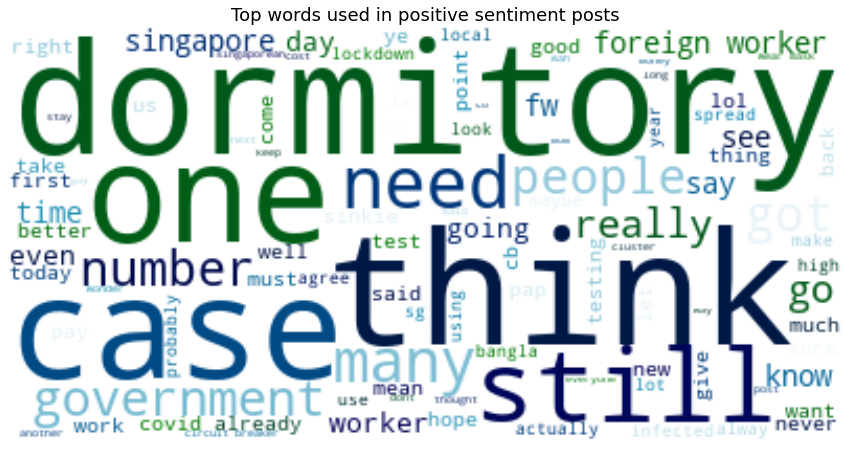

In [33]:
#generate wordcloud 

wc = WordCloud(max_words=100, background_color="white", 
               colormap = 'ocean').generate(all_posts['post_clean_lda'].to_string())
plt.figure(figsize = (15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title(f'Top words used in positive sentiment posts', fontsize= 18);

In [34]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [35]:
cvec = CountVectorizer()
cvec_data = cvec.fit_transform(all_posts['post_clean_lda'])

# Tweak the two parameters below
number_topics = 6
number_words = 15

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, n_jobs=-1, random_state=42)
lda.fit(cvec_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, cvec, number_words)

Topics found via LDA:

Topic #0:
using sent got like still saf going sm forums camp one hardwarezone go really cruise

Topic #1:
dormitory workers government like one people even think would foreign living test get pay conditions

Topic #2:
mask government need dormitory people think go say wear still better really one like workers

Topic #3:
people go think see time one like government pap back us many get still day

Topic #4:
workers dormitory foreign said singapore covid worker also minister migrant teo work mr measures mom

Topic #5:
cases dormitory new covid singapore testing number community total clusters may case still day moh


In [36]:
#optimising LDA model for neg sentiment data 

display(lda.score(cvec_data))
display(lda.perplexity(cvec_data))
display(lda.get_params())

-2123146.2779334956

3546.150219430111

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 6,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

In [14]:
#Attempting to optimise LDA model with GridsearchCV 

params = {'n_components': [5, 6, 7, 8, 9, 10], 'learning_decay': [.5, .7, .9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=params, n_jobs=-1, verbose=1)

model.fit(cvec_data)

display(model.best_params_)
display(model.score)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 33.1min finished


{'learning_decay': 0.9, 'n_components': 5}

<bound method BaseSearchCV.score of GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 6, 7, 8, 9, 10]},
             verbose=1)>

In [16]:
#topics from LDA model with optimised params
number_topics = 5
number_words = 15

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, n_jobs=-1, learning_decay=0.9, random_state=42)
lda.fit(cvec_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, cvec, number_words)

Topics found via LDA:

Topic #0:
said work singapore mom also minister teo testing test mr tested employers infected day days

Topic #1:
using still people go think sent see like need already even many cb time really

Topic #2:
government like people think need also conditions would pay operators living one better make get

Topic #3:
one back like government singapore many test us people go still say got time really

Topic #4:
singapore new total may 000 linked said community moh cluster clusters 10 20 confirmed one


## LDA mallet topic modeling 

In [37]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  

data_words = list(sent_to_words(all_posts['post_clean_lda']))

print(data_words[:1])

[['new', 'cluster', 'beside', 'dormitory', 'two', 'days']]


In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('beside', 1),
  ('cluster', 1),
  ('days', 1),
  ('dormitory', 1),
  ('new', 1),
  ('two', 1)]]

In [39]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/dorafoong/Desktop/capstone/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(13,
  [('pap', 0.03200096606690013),
   ('give', 0.019321338002656684),
   ('maids', 0.014853278589542326),
   ('sia', 0.011230527714044198),
   ('bangala', 0.01098901098901099),
   ('fark', 0.010868252626494384),
   ('check', 0.010868252626494384),
   ('forums', 0.010626735901461177),
   ('election', 0.010626735901461177),
   ('app', 0.010385219176427967)]),
 (1,
  [('cb', 0.03986710963455149),
   ('numbers', 0.030011074197120707),
   ('start', 0.02646733111849391),
   ('end', 0.025027685492801773),
   ('weeks', 0.02236987818383167),
   ('local', 0.018715393133997785),
   ('week', 0.017718715393133997),
   ('people', 0.016611295681063124),
   ('spread', 0.015503875968992248),
   ('lockdown', 0.014617940199335547)]),
 (12,
  [('cases', 0.12099821746880571),
   ('covid', 0.04085561497326203),
   ('singapore', 0.030374331550802137),
   ('dormitory', 0.028663101604278075),
   ('community', 0.02538324420677362),
   ('total', 0.02445632798573975),
   ('moh', 0.019750445632798572),
   ('li